# downloading dataset

In [21]:
!pip install kaggle
!pip install opencv-python
!pip install matplotlib
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 18.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 42.7 MB/s eta 0:00:0000:0100:01


In [16]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle competitions download -c bioverse-hackathon-a

bioverse-hackathon-a.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
%%capture
!unzip bioverse-hackathon-a.zip

# Importing packages

In [22]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam,SGD
from torchvision import models
import os
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import f1_score
import time
import warnings
warnings.filterwarnings("ignore")

# Reading dataset and apply EDA

In [24]:
import os
import cv2

# Define the root directory where your dataset is located
root_dir = 'train'

# Initialize lists to store images and their corresponding labels
image_dirs = []
labels = []

# Iterate through the class directories
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)

    # Iterate through the ID directories within each class directory
    for id_name in os.listdir(class_dir):
        id_dir = os.path.join(class_dir, id_name)

        # Iterate through the image files within each ID directory
        for image_name in os.listdir(id_dir):
            image_path = os.path.join(id_dir, image_name)

            # Append the image directory to the image_dirs list
            image_dirs.append(image_path)

            # Append the class label to the labels list
            labels.append(class_name)

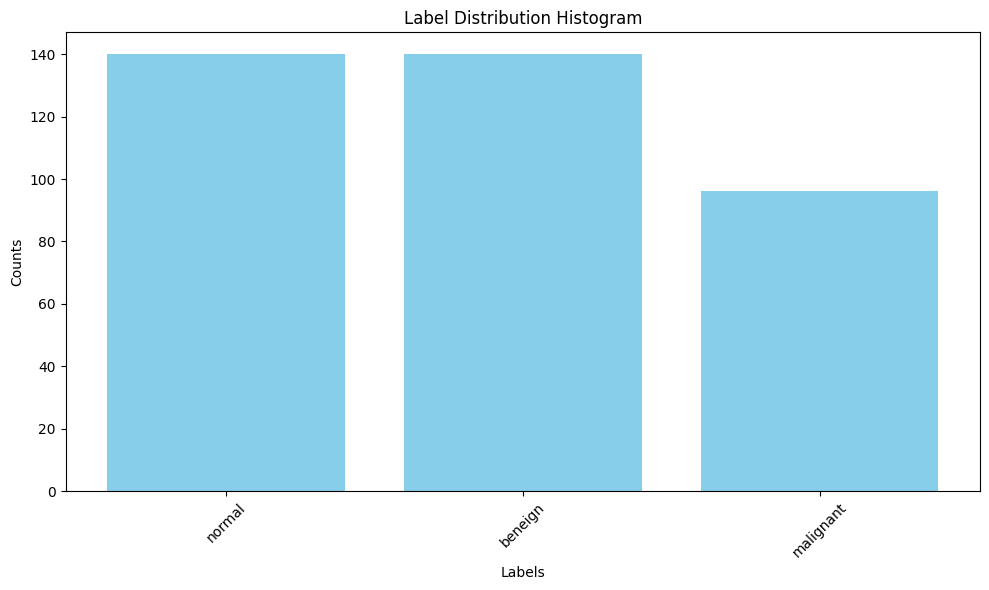

In [25]:
# Count the occurrences of each label
label_counts = {label: labels.count(label) for label in set(labels)}

# Extract labels and counts for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(label_names, label_values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Histogram')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

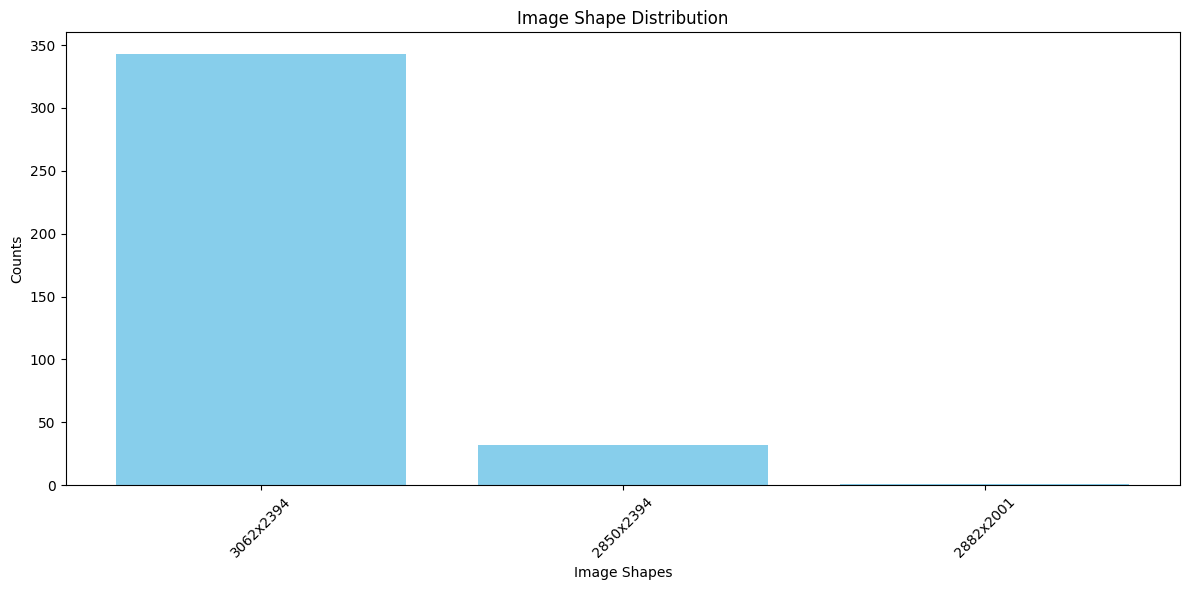

In [26]:
image_shape_counts = {}
for img in image_dirs:
  img = cv2.imread(img)
  image_shape = img.shape
  if image_shape in image_shape_counts:
      image_shape_counts[image_shape] += 1
  else:
      image_shape_counts[image_shape] = 1


# Extract image shapes and counts for plotting
shapes = list(image_shape_counts.keys())
counts = list(image_shape_counts.values())

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(shapes)), counts, tick_label=[f"{shape[0]}x{shape[1]}" for shape in shapes], color='skyblue')
plt.xlabel('Image Shapes')
plt.ylabel('Counts')
plt.title('Image Shape Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


# Preprocessing

In [27]:
def crop_biggest_contour(img, threshold_value):
    """
    function to get the biggest contour from the images and crop only breast from the image
    """
    # Read the image
    image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    _, thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the region of the largest contour from the original image
        cropped_image = image[y:y+h, x:x+w]

        return cropped_image
    else:
        print("No contours found.")
        return None

### In the dataset most of images have a big background around the breast so we are going to crop only the breast from the image

### Here is a sample

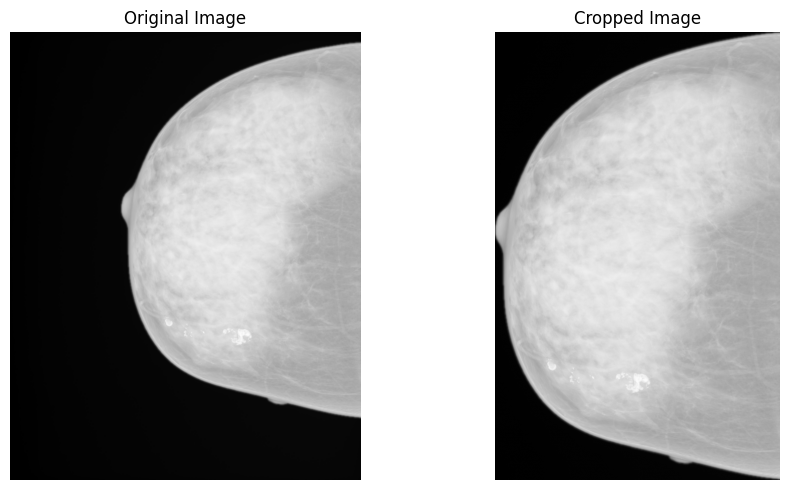

In [28]:
# Load the image
image = cv2.imread(image_dirs[0])

# Set the threshold value
threshold_value = 50

# Apply the function to get the cropped image
cropped_image = crop_biggest_contour(image, threshold_value)

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Cropped image
plt.subplot(1, 2, 2)
plt.imshow(cropped_image, cmap='gray')  # Assuming cropped image is grayscale
plt.title("Cropped Image")
plt.axis('off')

plt.tight_layout()
plt.show()

## from the histogram below classes beneign and normal  have samples more than the the malignant class so we will over sampling this class to achieve balance

In [29]:
# Convert the list of images to a numpy array
X = np.array(image_dirs).reshape(-1, 1)

# Flatten the labels
y = np.array(labels).reshape(-1, 1)

# Oversample the malignant class using RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversampler.fit_resample(X, y)


#here is the dataset after oversampling and making data balanced

### Exmple

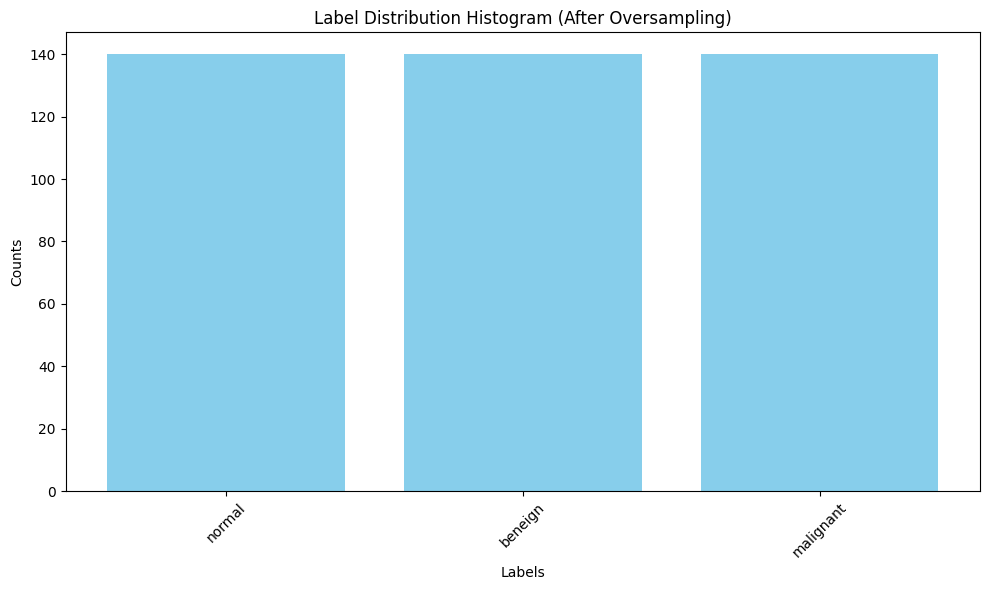

In [30]:
# Count the occurrences of each label after oversampling
label_counts = {label: list(y_resampled).count(label) for label in set(y_resampled)}

# Extract labels and counts for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(label_names, label_values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Histogram (After Oversampling)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Train Test Split

In [31]:
# Define the root directory where your dataset is located
root_dir = 'train'

# Initialize a dictionary to store the count of patients in each class
class_patients = {
    "beneign":[],
    "normal":[],
    "malignant":[],
}

# Iterate through the class directories
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)

    # Iterate through the ID directories within each class directory
    for id_name in os.listdir(class_dir):
        # Add the patient ID to the set
        class_patients[class_name].append(f'{root_dir}/{class_name}/{id_name}')


### create custom dataset folder

In [32]:
!rm -r custom_dataset

rm: cannot remove 'custom_dataset': No such file or directory


In [33]:
os.mkdir(os.path.join('', 'custom_dataset'))
os.mkdir(os.path.join('custom_dataset','train'))
os.mkdir(os.path.join('custom_dataset','test'))
for class_name in class_patients:
  os.mkdir(os.path.join('custom_dataset/train',class_name))
  os.mkdir(os.path.join('custom_dataset/test',class_name))

### here we will split data in 80% for train and 20% for test

In [34]:
train_dir = 'custom_dataset/train'
test_dir = 'custom_dataset/test'
for class_name,images_list in class_patients.items():
  test_patients_list = images_list[:7]
  train_patients_list = images_list[7:]

  for patient in test_patients_list:
    for img_path in os.listdir(f'{patient}'):
        img = cv2.imread(f'{patient}/{img_path}')
        img = crop_biggest_contour(img, threshold_value)
        img = cv2.resize(img,(256,256))

        flipped_image = cv2.flip(img, 1)

        rows, cols = img.shape
        rotation_angle = 15
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)

        rotated_image = cv2.warpAffine(img, M, (cols, rows))
        adjusted = cv2.convertScaleAbs(img, beta=-20)

        not_adjusted = cv2.convertScaleAbs(img, beta=20)

        gaussian_blurred_image = cv2.GaussianBlur(img, (5, 5), 0)

        cv2.imwrite(f'{test_dir}/{class_name}/{img_path}',img)


  for patient in train_patients_list:
    for img_path in os.listdir(f'{patient}'):
        img = cv2.imread(f'{patient}/{img_path}')
        img = crop_biggest_contour(img, threshold_value)
        img = cv2.resize(img,(256,256))
        flipped_image = cv2.flip(img, 1)
        rows, cols = img.shape
        rotation_angle = 15
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)
        rotated_image = cv2.warpAffine(img, M, (cols, rows))
        adjusted = cv2.convertScaleAbs(img, beta=-20)

        not_adjusted = cv2.convertScaleAbs(img, beta=20)

        gaussian_blurred_image = cv2.GaussianBlur(img, (5, 5), 0)

        cv2.imwrite(f'{train_dir}/{class_name}/{img_path}',img)
        cv2.imwrite(f'{train_dir}/{class_name}/{img_path.split(".")[0]}_flipped.jpg',flipped_image)
        cv2.imwrite(f'{train_dir}/{class_name}/{img_path.split(".")[0]}_rotated.jpg',rotated_image)
        cv2.imwrite(f'{train_dir}/{class_name}/{img_path.split(".")[0]}_brightened.jpg',adjusted)
        cv2.imwrite(f'{train_dir}/{class_name}/{img_path.split(".")[0]}_not_brightened.jpg',not_adjusted)

### for applying balance in train dataset

In [35]:
# Define the root directory where your dataset is located
root_dir = 'custom_dataset/train'

# Initialize lists to store images and their corresponding labels
image_dirs = []
labels = []

# Iterate through the class directories
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)

    # Iterate through the ID directories within each class directory
    for id_name in os.listdir(class_dir):
        id_dir = os.path.join(class_dir, id_name)

        # Iterate through the image files within each ID directory
        image_path = os.path.join(id_dir)

        # Append the image to the image_dirs list
        image_dirs.append(image_path)

        # Append the class label to the labels list
        labels.append(class_name)

In [36]:
# Convert the list of images to a numpy array
X = np.array(image_dirs).reshape(-1, 1)

# Flatten the labels
y = np.array(labels).reshape(-1, 1)

# Oversample the malignant class using RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversampler.fit_resample(X, y)

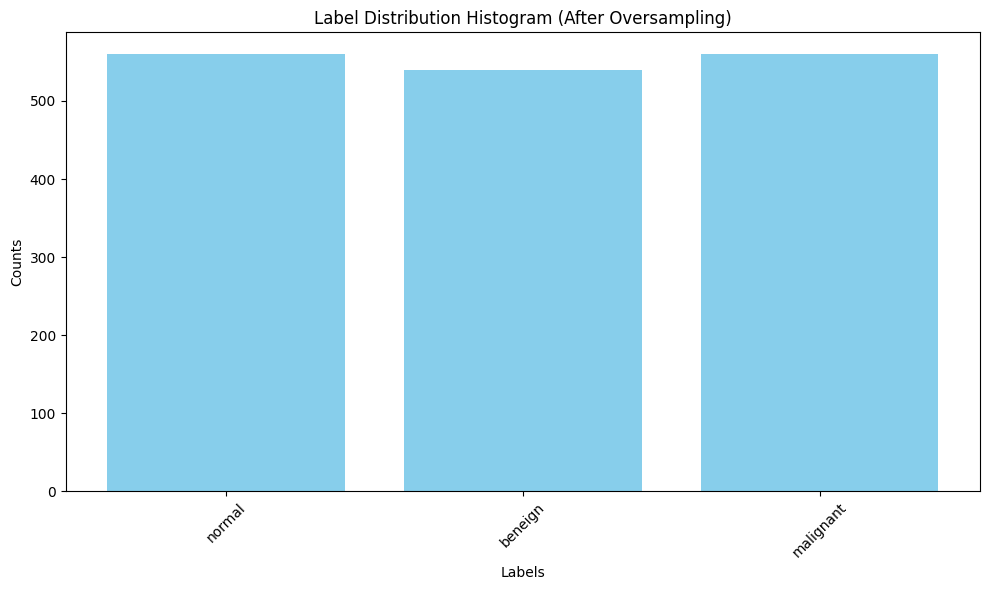

In [37]:
# Count the occurrences of each label after oversampling
label_counts = {label: list(y_resampled).count(label) for label in set(y_resampled)}

# Extract labels and counts for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(label_names, label_values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Histogram (After Oversampling)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Custom dataset loader

In [38]:
class CustomDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.data_dirs = data_dirs
        self.transform = transform
        self.labels = {
              "normal":2,
              "beneign":0,
              "malignant":1,
          }

    def __len__(self):
        return len(self.data_dirs)

    def __getitem__(self, idx):
        image_path= self.data_dirs[idx][0]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        class_name = self.labels[image_path.split('/')[2]]
        class_name = torch.tensor(class_name, dtype=torch.long)


        if self.transform:
            image = self.transform(image)

        return image, class_name

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [40]:
batch_size = 32

train_dataset = CustomDataset(X_resampled,transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_dir = 'custom_dataset/test/'
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Loading the model

In [41]:
models.swin_v2_b(pretrained=True).head

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /home/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:31<00:00, 11.2MB/s] 


Linear(in_features=1024, out_features=1000, bias=True)

In [42]:
# Load pretrained swin_v2_b model
model = models.swin_v2_b(pretrained=True)

model.head = nn.Sequential(nn.Linear(1024, 128),
                           nn.Dropout1d(0.45),
                           nn.Linear(128, 3))

# Change the number of input channels in the first convolution layer to match your data
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)

# Training the model

In [43]:
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr= 0.000001)

In [44]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1, patience=3, min_lr=1e-6):
    model = model.to('cuda')
    optimizer = optimizer
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, min_lr=min_lr)

    best_val_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0

    history = {
        'train_acc': [],
        'train_loss': [],
        'test_acc': [],
        'test_loss': [],

    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_steps = len(train_loader)
        corrects = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        for step, (inputs, labels) in enumerate(train_loader, 1):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            f1 = f1_score(all_labels, all_preds, average='macro')

            print(f"\rEpoch {epoch + 1}/{num_epochs}, Step {step}/{total_steps}, Loss: {loss.item():.4f}, Accuracy: {corrects.double() / total_samples:.4f}, F1: {f1}", end='')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = corrects.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        corrects = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to('cuda'), val_labels.to('cuda')
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item() * val_inputs.size(0)
                _, preds = torch.max(val_outputs, 1)
                corrects += torch.sum(preds == val_labels.data)
                total_samples += val_inputs.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_accuracy = corrects.double() / len(val_loader.dataset)

        f1 = f1_score(all_labels, all_preds, average='macro')
        print(f"\nEpoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {f1}\n")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping! No improvement for {} epochs.".format(patience))
                break

        history['train_acc'].append(epoch_accuracy)
        history['train_loss'].append(epoch_loss)
        history['test_acc'].append(val_accuracy)
        history['test_loss'].append(val_loss)

    print(f"Training completed. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch + 1}")

    return history

In [45]:
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=33, patience=7)

Epoch 1/33, Step 52/52, Loss: 1.1557, Accuracy: 0.3367, F1: 0.29654087928121625
Epoch 1/33, Validation Loss: 1.0864, Validation Accuracy: 0.3690, Validation F1: 0.3629221059332504

Epoch 2/33, Step 52/52, Loss: 1.0604, Accuracy: 0.3711, F1: 0.34203122997209373
Epoch 2/33, Validation Loss: 1.0732, Validation Accuracy: 0.4167, Validation F1: 0.41361275172561013

Epoch 3/33, Step 52/52, Loss: 1.0742, Accuracy: 0.3867, F1: 0.36993803251113195
Epoch 3/33, Validation Loss: 1.0588, Validation Accuracy: 0.4524, Validation F1: 0.4537784228350266

Epoch 4/33, Step 52/52, Loss: 1.0551, Accuracy: 0.4229, F1: 0.40989516260874943
Epoch 4/33, Validation Loss: 1.0432, Validation Accuracy: 0.4762, Validation F1: 0.4747850017199862

Epoch 5/33, Step 52/52, Loss: 0.9679, Accuracy: 0.4494, F1: 0.43594563955605117
Epoch 5/33, Validation Loss: 1.0279, Validation Accuracy: 0.5119, Validation F1: 0.5085613790970934

Epoch 6/33, Step 52/52, Loss: 0.9938, Accuracy: 0.4843, F1: 0.47269679575867934
Epoch 6/33, Va

{'train_acc': [tensor(0.3367, device='cuda:0', dtype=torch.float64),
  tensor(0.3711, device='cuda:0', dtype=torch.float64),
  tensor(0.3867, device='cuda:0', dtype=torch.float64),
  tensor(0.4229, device='cuda:0', dtype=torch.float64),
  tensor(0.4494, device='cuda:0', dtype=torch.float64),
  tensor(0.4843, device='cuda:0', dtype=torch.float64),
  tensor(0.5301, device='cuda:0', dtype=torch.float64),
  tensor(0.5211, device='cuda:0', dtype=torch.float64),
  tensor(0.5199, device='cuda:0', dtype=torch.float64),
  tensor(0.5386, device='cuda:0', dtype=torch.float64),
  tensor(0.5373, device='cuda:0', dtype=torch.float64),
  tensor(0.5482, device='cuda:0', dtype=torch.float64),
  tensor(0.5693, device='cuda:0', dtype=torch.float64),
  tensor(0.5608, device='cuda:0', dtype=torch.float64),
  tensor(0.5657, device='cuda:0', dtype=torch.float64),
  tensor(0.5663, device='cuda:0', dtype=torch.float64),
  tensor(0.5633, device='cuda:0', dtype=torch.float64),
  tensor(0.5976, device='cuda:0', d

# Prepare image for predicting

In [46]:
def prepare_img(image):
  # Define transformations
  transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize images to the model's input size
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
  ])

  image_tensor = transform(image).unsqueeze(0).to('cuda')

  return image_tensor


In [47]:
def predict(image,model):
  image_tensor = prepare_img(image)  # Add batch dimension
  with torch.no_grad():
      output = model(image_tensor)
      predicted_class = output.argmax(dim=1).item()
      predictions.append(val_dataset.classes[predicted_class])

# Generating submition file

In [48]:
image_folder = 'test'
image_paths = [os.path.join(image_folder, img_name) for img_name in os.listdir(image_folder)]

predictions = []

model.eval()  # Set the model to evaluation mode

labels = {
          2:"normal",
          0:"beneign",
          1:"malignant",
          }


for image_path in image_paths:
  image = Image.open(image_path).convert("RGB")
  predict(image,model)

In [49]:
# Extract image names from image paths
image_names = [os.path.basename(path) for path in image_paths]

# Create a DataFrame with image names and predictions
data = {'filename': image_names, 'class': predictions}
df = pd.DataFrame(data)

# Save DataFrame to a CSV file
csv_file = 'predictions3.csv'
df.to_csv(csv_file, index=False)
print("Predictions saved to:", csv_file)


Predictions saved to: predictions3.csv


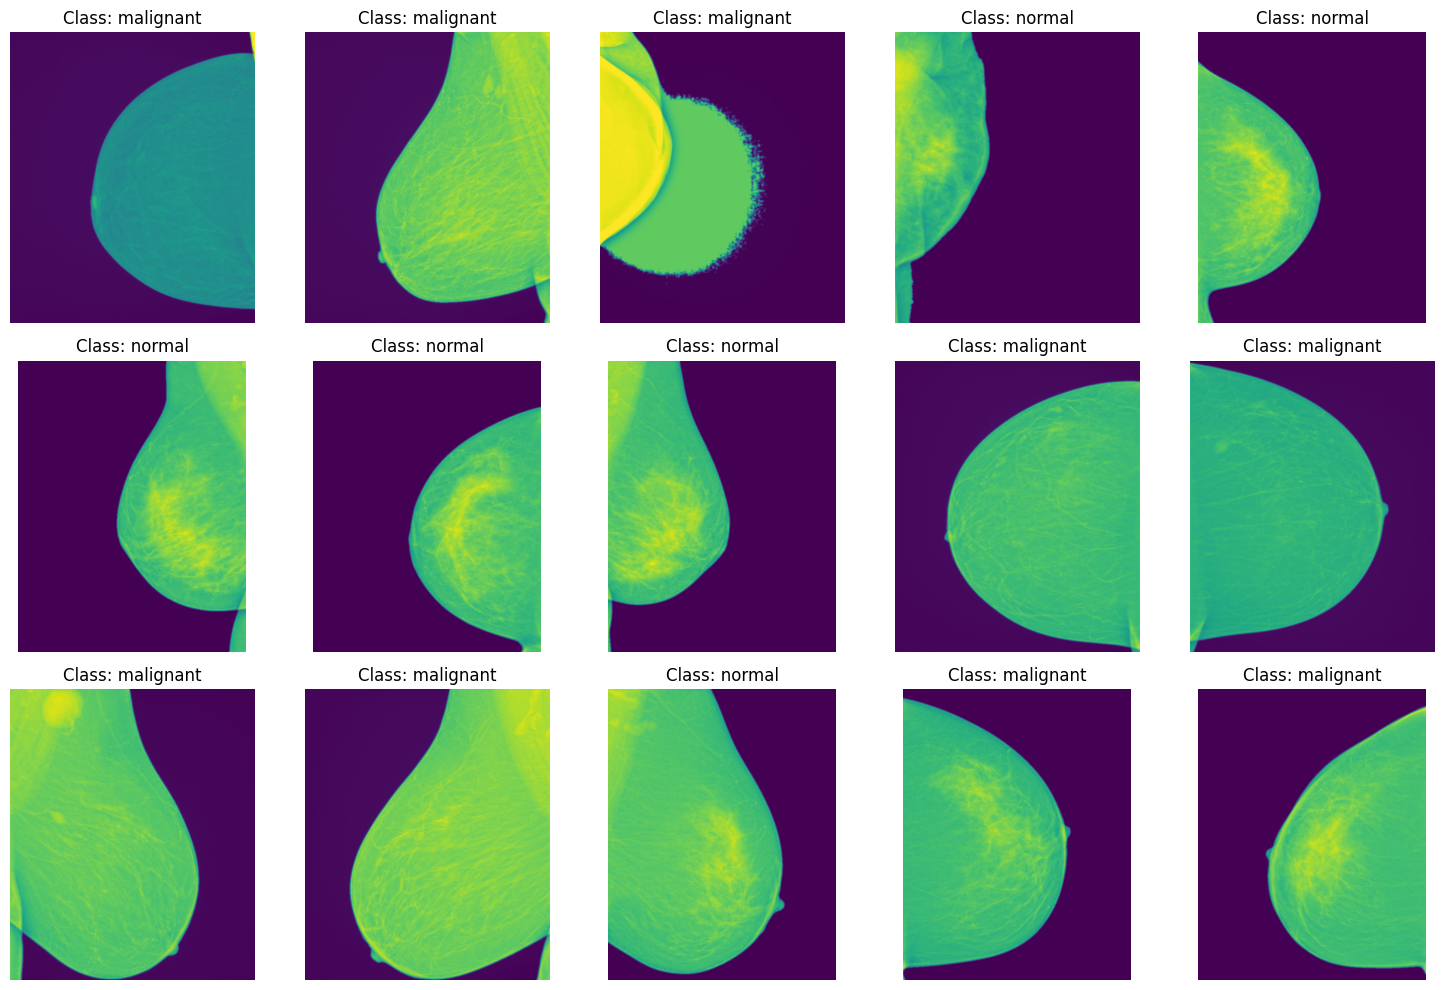

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load the CSV file
csv_file = 'predictions3.csv'
df = pd.read_csv(csv_file)

# Define the path to your test folder
test_folder = 'test/'

# Set the number of images to display
num_images = 15  # Change this to display more/less images

# Plot images with predictions
plt.figure(figsize=(15, 10))

for i, row in df.head(num_images).iterrows():
    img_path = os.path.join(test_folder, row['filename'])
    
    # Check if the image exists
    if os.path.exists(img_path):
        img = Image.open(img_path)
        
        # Create a subplot for each image
        plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns (change based on num_images)
        plt.imshow(img)
        plt.title(f"Class: {row['class']}")
        plt.axis('off')
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()


# Calcuating inference time

In [50]:
image = Image.open(image_paths[0]).convert("RGB")
start = time.time()
predict(image,model)
end = time.time()


print(f'time taken for model to predict on one sample is: {round(end-start,2)} S')


time taken for model to predict on one sample is: 0.11 S


In [51]:
image = Image.open(image_paths[0]).convert("RGB")

val_dir = 'custom_dataset/test/'
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

start = time.time()
for x,y in val_loader:
  x, y = x.to('cuda'), y.to('cuda')
  output = model(x)
  _, preds = torch.max(output, 1)
  break
end = time.time()


print(f'time taken for model to train on one sample is: {round(end-start,2)} S')

time taken for model to train on one sample is: 0.1 S
